### Data Preparation

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
covid_original = pd.read_csv("owid-covid-data.csv")

In [7]:
covid_original.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
0,AFG,Asia,Afghanistan,2019-12-31,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
1,AFG,Asia,Afghanistan,2020-01-01,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
2,AFG,Asia,Afghanistan,2020-01-02,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
3,AFG,Asia,Afghanistan,2020-01-03,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
4,AFG,Asia,Afghanistan,2020-01-04,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5


#### Goal: How long did European countries/USA/Canada/Australia/New Zealand take to control the virus?
Method: Stable date - Starting date, yielding number of days

Starting date: the first date when the confirmed cases reached over 30
Stable date: 
1. Find the median of total confirmed case, locate the date when confirmed case reached "median". I named it as "median_date"
2. Calculate the moving average. [Algorithm: (Today total case - Yesterday total case) / Yesterday total case]
3. Focus only on the dates after the median date, and collect the dates in a list which is named as "moving_date_list"
4. The median of "moving_date_list" is set as the "Stable date".

#### Step 1. 

In [8]:
country=["Germany"
         ,"Russia"
         ,"United Kingdom","France","Italy","Spain","Ukraine","Poland","Romania","Netherlands","Belgium","Czech Republic","Greece","Portugal"
,"Sweden"
,"Hungary"
,"Belarus"
,"Austria"
,"Serbia"
,"Switzerland"
,"Bulgaria"
,"Denmark"
,"Finland"
,"Slovakia"
,"Norway"
,"Ireland"
,"Croatia"
,"Moldova"
,"Bosnia and Herzegovina"
,"Albania"
,"Lithuania"
,"North Macedonia"
,"Slovenia"
,"Latvia"
,"Estonia"
,"Montenegro"
,"Luxembourg"
,"Malta"
,"Iceland"
,"Canada"
,"Australia"
,"New Zealand"]

In [9]:
def median_date(i):
    country_case = covid_original.loc[(covid_original["location"] ==i)&(covid_original["total_cases"]>=30), ["date","total_cases"]]
    country_case["date"] = pd.to_datetime(country_case["date"],format="%Y-%m-%d")
    median_num = country_case.total_cases.median()
    date_over_median = covid_original.loc[(covid_original["location"] ==i)&(covid_original["total_cases"]>=median_num), ["date","total_cases"]]
    date_over_median_list = date_over_median["date"].tolist()
    date = date_over_median_list[0]
    return date

#### Step 2.

In [10]:
def moving_rate_table(country):
    date = []
    case = []
    country_case = covid_original.loc[(covid_original["location"] ==country)&(covid_original["total_cases"]>=30), ["date","total_cases"]]
    for i in country_case["date"]:
        date.append(i)
    for i in country_case["total_cases"]:
        case.append(i)
    change_rate = []
    for index, value in enumerate(case):
        try:
            rate = ((case[index+1] - value)/value)*100
            change_rate.append(rate)
        except:
            pass
    change_rate = np.asarray(change_rate)
    data = {"Date":date[1:], "Change Rate":change_rate}
    df = pd.DataFrame(data)
    df["Date"] = pd.to_datetime(df["Date"],format="%Y-%m-%d")
    return df

#### Step 3. 

In [11]:
def calculate_quarlitle(df,median_date):
    new_df = df.loc[df["Date"]>median_date,:]
    new_df_quantile = new_df.quantile([0.25,0.5,0.75])
    new_df_average = new_df_quantile["Change Rate"].tolist()
    get_average = new_df_average[1]
    return get_average

#### Step 4.

In [12]:
def days_to_stable(i,df,date,mean):
    new_df = df.loc[df["Date"]>date,:]
    mean = mean-0.1
    stable_date = new_df.loc[df["Change Rate"]<=mean,:"Date"]
    stable_date_list = stable_date["Date"].tolist()
    country_case = covid_original.loc[(covid_original["location"] ==i)&(covid_original["total_cases"]>=30), ["date","total_cases"]]
    country_case["date"] = pd.to_datetime(country_case["date"],format="%Y-%m-%d")
    day_to_stable = stable_date_list[2] - country_case["date"].min()
    day_to_stable = day_to_stable.days
    return day_to_stable

In [13]:
dic = {}

#### Compile all the functions

In [14]:
for i in country:
    try:
        median = median_date(i)
        change_df = moving_rate_table(i)
        average = calculate_quarlitle(change_df,median)
        to_stable = days_to_stable(i,change_df,median,average)
        dic[i] = to_stable
    except:
        print(f"{i} occured error")

North Macedonia occured error
Slovenia occured error
Montenegro occured error
Iceland occured error
New Zealand occured error


In [15]:
dic

{'Germany': 80,
 'Russia': 69,
 'United Kingdom': 80,
 'France': 79,
 'Italy': 88,
 'Spain': 80,
 'Ukraine': 60,
 'Poland': 59,
 'Romania': 69,
 'Netherlands': 76,
 'Belgium': 76,
 'Czech Republic': 57,
 'Greece': 57,
 'Portugal': 55,
 'Sweden': 60,
 'Hungary': 64,
 'Belarus': 65,
 'Austria': 63,
 'Serbia': 64,
 'Switzerland': 92,
 'Bulgaria': 59,
 'Denmark': 75,
 'Finland': 71,
 'Slovakia': 67,
 'Norway': 72,
 'Ireland': 70,
 'Croatia': 74,
 'Moldova': 47,
 'Bosnia and Herzegovina': 55,
 'Albania': 50,
 'Lithuania': 46,
 'Latvia': 55,
 'Estonia': 54,
 'Luxembourg': 70,
 'Malta': 48,
 'Canada': 77,
 'Australia': 83}

### * Fixing error 

In [16]:
country_case_NM = covid_original.loc[(covid_original["location"] =="North Macedonia")&(covid_original["total_cases"]>=30), ["date","total_cases"]]

#### Can't find North Macedonia resources in the database, will remove it

In [17]:
country_case_NM

,date,total_cases


#### Slovenia will take 62 days to control the virus

In [18]:
median_slv = median_date("Slovenia")

In [19]:
df_slv = moving_rate_table("Slovenia")

In [20]:
cq_slv = calculate_quarlitle(df_slv,median_slv)

In [21]:
new_df_slv = df_slv.loc[df_slv["Date"]>median_slv,:]
stable_date = new_df_slv.loc[df_slv["Change Rate"]<cq_slv,:"Date"]
stable_date_list = stable_date["Date"].tolist()
country_case = covid_original.loc[(covid_original["location"] =="Slovenia")&(covid_original["total_cases"]>=30), ["date","total_cases"]]
country_case["date"] = pd.to_datetime(country_case["date"],format="%Y-%m-%d")
day_to_stable_slv = stable_date_list[2] - country_case["date"].min()

In [22]:
day_to_stable_slv

Timedelta('62 days 00:00:00')

### Montenegro

In [23]:
median_mtg = median_date("Montenegro")

In [24]:
df_mtg = moving_rate_table("Montenegro")

In [25]:
new_df_mtg = df_mtg.loc[df_mtg["Date"]>median_mtg,:]
mtg_stable_list = new_df_mtg.loc[df_mtg["Change Rate"]== 0.0,:"Date"]
mtg_stable_list = stable_date["Date"].tolist()

In [26]:
mtg_date = mtg_stable_list[0]

In [27]:
mtg_date

Timestamp('2020-04-28 00:00:00')

In [28]:
mtg_case = covid_original.loc[(covid_original["location"] =="Montenegro")&(covid_original["total_cases"]>=30), ["date","total_cases"]]
mtg_case["date"] = pd.to_datetime(mtg_case["date"],format="%Y-%m-%d")

In [29]:
day_to_stable_mtg = mtg_date - mtg_case["date"].min()

#### Montenegro will take 34 days to control the virus

In [30]:
day_to_stable_mtg

Timedelta('34 days 00:00:00')

### Iceland

In [31]:
median_lc = median_date("Iceland")

In [32]:
df_lc = moving_rate_table("Iceland")

In [33]:
cq_lc = calculate_quarlitle(df_lc,median_lc)

In [34]:
new_df_lc = df_lc.loc[df_lc["Date"]>median_lc,:]
lc_stable_list = new_df_lc.loc[df_lc["Change Rate"]<= cq_lc,:"Date"]
lc_stable_list = lc_stable_list["Date"].tolist()

In [35]:
lc_date = lc_stable_list[0]

In [36]:
lc_date

Timestamp('2020-04-25 00:00:00')

In [37]:
lc_case = covid_original.loc[(covid_original["location"] =="Iceland")&(covid_original["total_cases"]>=30),["date","total_cases"]]
lc_case["date"] = pd.to_datetime(lc_case["date"],format="%Y-%m-%d")

In [38]:
day_to_stable_lc = lc_date - lc_case["date"].min()

#### Iceland will take 50 days to control the virus

In [39]:
day_to_stable_lc

Timedelta('50 days 00:00:00')

### New Zealand

In [40]:
median_nz =  median_date("New Zealand")

In [41]:
df_nz = moving_rate_table("New Zealand")

In [42]:
cq_nz = calculate_quarlitle(df_nz,median_nz)

In [43]:
new_df_nz = df_nz.loc[df_nz["Date"]>median_nz,:]
nz_stable_list = new_df_nz.loc[df_nz["Change Rate"]<= cq_nz,:"Date"]
nz_stable_list = nz_stable_list["Date"].tolist()

In [44]:
nz_date = nz_stable_list[0]

In [45]:
nz_case = covid_original.loc[(covid_original["location"] =="New Zealand")&(covid_original["total_cases"]>=30),["date","total_cases"]]
nz_case["date"] = pd.to_datetime(nz_case["date"],format="%Y-%m-%d")

In [46]:
day_to_stable_nz = nz_date - nz_case["date"].min()

##### New Zealand will take 46 days to control the virus

In [47]:
day_to_stable_nz

Timedelta('46 days 00:00:00')

#### Result of error countries
- North Macedonia: NA
- Montenegro: 31 days
- Iceland: 51 days
- New Zealand: 46 days
- Slovenia: 62 days

In [48]:
dic["Slovenia"] = 62
dic["Montenegro"] = 31
dic["Iceland"] =51
dic["New Zealand"] = 46
dic["Slovenia"] = 62

In [49]:
dic

{'Germany': 80,
 'Russia': 69,
 'United Kingdom': 80,
 'France': 79,
 'Italy': 88,
 'Spain': 80,
 'Ukraine': 60,
 'Poland': 59,
 'Romania': 69,
 'Netherlands': 76,
 'Belgium': 76,
 'Czech Republic': 57,
 'Greece': 57,
 'Portugal': 55,
 'Sweden': 60,
 'Hungary': 64,
 'Belarus': 65,
 'Austria': 63,
 'Serbia': 64,
 'Switzerland': 92,
 'Bulgaria': 59,
 'Denmark': 75,
 'Finland': 71,
 'Slovakia': 67,
 'Norway': 72,
 'Ireland': 70,
 'Croatia': 74,
 'Moldova': 47,
 'Bosnia and Herzegovina': 55,
 'Albania': 50,
 'Lithuania': 46,
 'Latvia': 55,
 'Estonia': 54,
 'Luxembourg': 70,
 'Malta': 48,
 'Canada': 77,
 'Australia': 83,
 'Slovenia': 62,
 'Montenegro': 31,
 'Iceland': 51,
 'New Zealand': 46}

## Build/Convert Training Dataset

In [50]:
covid_data = pd.read_csv("COVID Data Collection _ copy.csv")

In [51]:
covid_data["Days to Stability"] = covid_data["Country"].map(dic)

In [52]:
covid_data.columns

Index(['Country', 'Young Population\n(Aged under 15 )',
       'Working Age Population\n(Aged between 15 - 64)',
       'Elderly population\n(Aged 65 and over)', 'Population ',
       'Population Density \n(per Km2)', 'Political Ideology ', 'Death Rate',
       'Social Distancing\n(days)', 'Wearing Face mask\n(days)',
       '14 day Quarantine\n(days)', 'Boarders\n(days)',
       'School closures\n(days)', 'Lockdown', 'Days to Peak',
       'Days to Stability'],
      dtype='object')

### Processing data
-  Set country as index
- Convert Young population/Working Age population/Elderly population/Death Rate to int
- Covert Political Ideology/Lockdown to int indicators
- "Days to Stability" has 2 missing value

In [53]:
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 16 columns):
Country                                          43 non-null object
Young Population
(Aged under 15 )                43 non-null object
Working Age Population
(Aged between 15 - 64)    43 non-null object
Elderly population
(Aged 65 and over)            43 non-null object
Population                                       43 non-null int64
Population Density 
(per Km2)                    43 non-null int64
Political Ideology                               43 non-null object
Death Rate                                       43 non-null object
Social Distancing
(days)                         43 non-null int64
Wearing Face mask
(days)                         43 non-null int64
14 day Quarantine
(days)                         43 non-null int64
Boarders
(days)                                  43 non-null int64
School closures
(days)                           43 non-null int64
Lockdown            

In [54]:
covid_data.set_index("Country",inplace = True)

In [55]:
covid_data.columns

Index(['Young Population\n(Aged under 15 )',
       'Working Age Population\n(Aged between 15 - 64)',
       'Elderly population\n(Aged 65 and over)', 'Population ',
       'Population Density \n(per Km2)', 'Political Ideology ', 'Death Rate',
       'Social Distancing\n(days)', 'Wearing Face mask\n(days)',
       '14 day Quarantine\n(days)', 'Boarders\n(days)',
       'School closures\n(days)', 'Lockdown', 'Days to Peak',
       'Days to Stability'],
      dtype='object')

In [56]:
covid_data.dtypes

Young Population\n(Aged under 15 )                 object
Working Age Population\n(Aged between 15 - 64)     object
Elderly population\n(Aged 65 and over)             object
Population                                          int64
Population Density \n(per Km2)                      int64
Political Ideology                                 object
Death Rate                                         object
Social Distancing\n(days)                           int64
Wearing Face mask\n(days)                           int64
14 day Quarantine\n(days)                           int64
Boarders\n(days)                                    int64
School closures\n(days)                             int64
Lockdown                                           object
Days to Peak                                        int64
Days to Stability                                 float64
dtype: object

In [57]:
# Convert all the population / Death rate into float
covid_data["Young Population\n(Aged under 15 )"] = covid_data["Young Population\n(Aged under 15 )"].astype(str).str.rstrip("%").astype(float)
covid_data["Working Age Population\n(Aged between 15 - 64)"] = covid_data["Working Age Population\n(Aged between 15 - 64)"].astype(str).str.rstrip("%").astype(float)
covid_data["Elderly population\n(Aged 65 and over)"] = covid_data["Elderly population\n(Aged 65 and over)"].astype(str).str.rstrip("%").astype(float)
covid_data["Death Rate"] = covid_data["Death Rate"].astype(str).str.rstrip("%").astype(float)

In [58]:
# Convert columns to int indicator
covid_data.replace("Y",1,inplace = True)
covid_data.replace("N",0,inplace=True)

In [59]:
covid_data.groupby("Political Ideology ").size()

Political Ideology 
Authoritarian        2
Flawed Democracy    17
Full Democracy      18
Hybrid Regime        6
dtype: int64

### Reset indicator as following
- Authoritarian: 1
- Flawed Democracy: 2
- Full Democracy: 3
- Hybrid Regime: 4

In [60]:
covid_data.replace("Authoritarian",1,inplace = True)
covid_data.replace("Flawed Democracy",2,inplace = True)
covid_data.replace("Full Democracy",3,inplace = True)
covid_data.replace("Hybrid Regime",4,inplace = True)

In [61]:
covid_data.head()

,Young Population (Aged under 15 ),Working Age Population (Aged between 15 - 64),Elderly population (Aged 65 and over),Population,Population Density (per Km2),Political Ideology,Death Rate,Social Distancing (days),Wearing Face mask (days),14 day Quarantine (days),Boarders (days),School closures (days),Lockdown,Days to Peak,Days to Stability
Country,,,,,,,,,,,,,,,
USA,18.62,65.35,16.03,32823952,34,2,5.60,103,0,149,109,106,1,106,NaN
Germany,13.50,65.00,21.47,83783942,240,3,4.70,49,44,70,91,52,1,100,80.0
Russia,17.91,67.41,14.67,145934462,9,1,1.25,45,64,0,104,0,1,85,69.0
United Kingdom,18.90,63.10,18.00,67886011,281,3,14.20,99,15,60,105,87,1,97,80.0
France,18.10,62.20,19.70,65273511,119,3,18.97,55,51,50,70,55,1,100,79.0


### Cleaning the NA value

In [62]:
covid_train = covid_data.copy()

In [63]:
covid_train.drop(["USA"],inplace = True)

In [64]:
covid_train.head()

,Young Population (Aged under 15 ),Working Age Population (Aged between 15 - 64),Elderly population (Aged 65 and over),Population,Population Density (per Km2),Political Ideology,Death Rate,Social Distancing (days),Wearing Face mask (days),14 day Quarantine (days),Boarders (days),School closures (days),Lockdown,Days to Peak,Days to Stability
Country,,,,,,,,,,,,,,,
Germany,13.50,65.00,21.47,83783942,240,3,4.70,49,44,70,91,52,1,100,80.0
Russia,17.91,67.41,14.67,145934462,9,1,1.25,45,64,0,104,0,1,85,69.0
United Kingdom,18.90,63.10,18.00,67886011,281,3,14.20,99,15,60,105,87,1,97,80.0
France,18.10,62.20,19.70,65273511,119,3,18.97,55,51,50,70,55,1,100,79.0
Italy,13.50,63.50,23.00,60461826,206,2,14.41,70,63,86,67,118,1,105,88.0


In [65]:
covid_train["Days to Stability"] = covid_train["Days to Stability"].fillna( covid_train["Days to Stability"].mean())

### Deeply look into the training data

In [66]:
covid_train.describe()

,Young Population (Aged under 15 ),Working Age Population (Aged between 15 - 64),Elderly population (Aged 65 and over),Population,Population Density (per Km2),Political Ideology,Death Rate,Social Distancing (days),Wearing Face mask (days),14 day Quarantine (days),Boarders (days),School closures (days),Lockdown,Days to Peak,Days to Stability
count,42.000000,42.000000,42.000000,4.200000e+01,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,16.397857,66.138333,17.458095,1.940880e+07,138.880952,2.666667,5.744762,62.333333,37.857143,78.880952,77.047619,86.928571,0.952381,86.928571,64.780488
std,2.360549,2.230850,3.019150,2.903403e+07,221.471377,0.786057,4.504750,34.017690,35.209873,44.528534,37.398939,31.526522,0.215540,10.416668,12.866125
min,13.500000,62.200000,8.900000,3.412430e+05,3.000000,1.000000,0.550000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000,31.000000
25%,14.725000,64.900000,15.150000,3.469105e+06,44.000000,2.000000,2.742500,39.000000,0.000000,52.500000,68.500000,67.250000,1.000000,83.250000,55.500000
50%,15.850000,65.950000,18.200000,8.695996e+06,89.000000,3.000000,4.515000,55.500000,41.000000,106.000000,91.500000,106.000000,1.000000,87.000000,64.390244
75%,17.725000,67.100000,19.650000,1.871199e+07,123.750000,3.000000,6.630000,98.750000,66.250000,109.000000,103.750000,110.000000,1.000000,93.750000,74.750000
max,25.000000,73.400000,23.000000,1.459345e+08,1380.000000,4.000000,18.970000,123.000000,109.000000,123.000000,107.000000,118.000000,1.000000,105.000000,92.000000


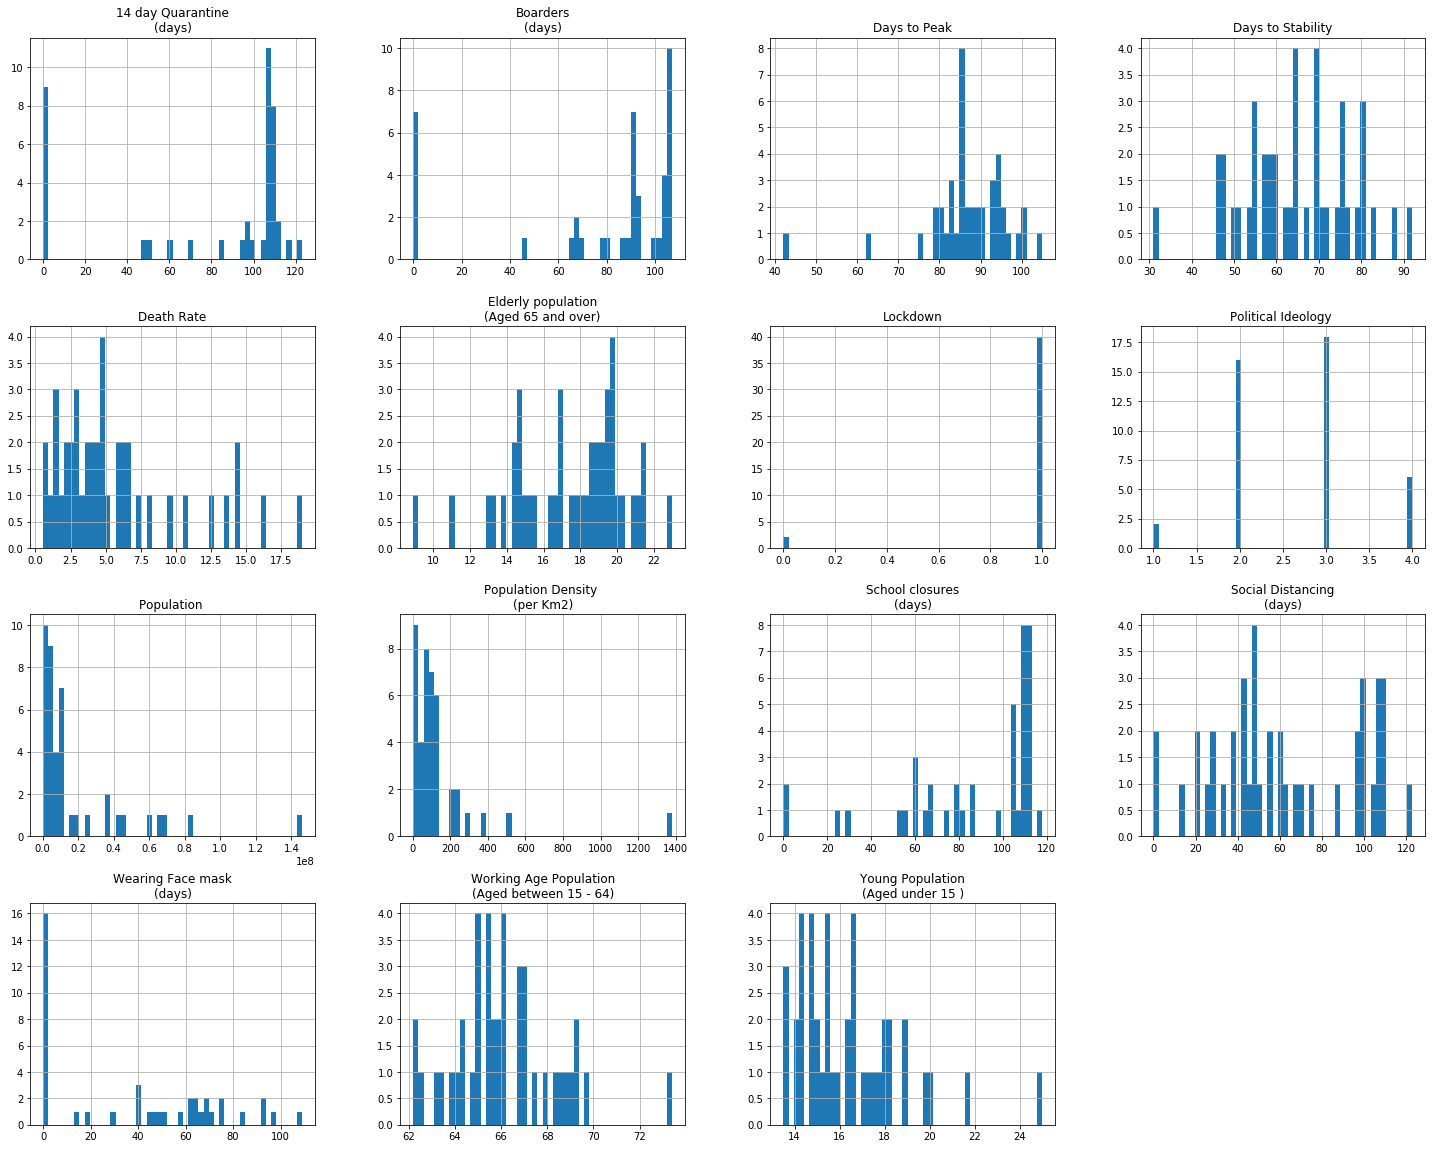

In [67]:
# see the data distribution
covid_train.hist(bins=50, figsize=(25,20))
plt.show()

### Prepare data for machine learning
- Feature Scaling: Since all the features have different units and magnitude, I adopted feature scaling.

In [68]:
from sklearn import preprocessing 

In [69]:
Standardisation = preprocessing.StandardScaler() 

In [70]:
covid_train.head()

,Young Population (Aged under 15 ),Working Age Population (Aged between 15 - 64),Elderly population (Aged 65 and over),Population,Population Density (per Km2),Political Ideology,Death Rate,Social Distancing (days),Wearing Face mask (days),14 day Quarantine (days),Boarders (days),School closures (days),Lockdown,Days to Peak,Days to Stability
Country,,,,,,,,,,,,,,,
Germany,13.50,65.00,21.47,83783942,240,3,4.70,49,44,70,91,52,1,100,80.0
Russia,17.91,67.41,14.67,145934462,9,1,1.25,45,64,0,104,0,1,85,69.0
United Kingdom,18.90,63.10,18.00,67886011,281,3,14.20,99,15,60,105,87,1,97,80.0
France,18.10,62.20,19.70,65273511,119,3,18.97,55,51,50,70,55,1,100,79.0
Italy,13.50,63.50,23.00,60461826,206,2,14.41,70,63,86,67,118,1,105,88.0


In [71]:
fs_data = covid_train.iloc[:,:-1]

In [72]:
fs_data_after_standardisation= Standardisation.fit_transform(fs_data) 

### Select and train the model

#### Started from the basic linear regression model

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [74]:
X = fs_data_after_standardisation

In [75]:
Y = covid_train["Days to Stability"].tolist()

In [76]:
X

array([[-1.24250063e+00, -5.16454156e-01,  1.34492658e+00,
         2.24410764e+00,  4.62112889e-01,  4.29197538e-01,
        -2.34735787e-01, -3.96704047e-01,  1.76578843e-01,
        -2.01861669e-01,  3.77591115e-01, -1.12134042e+00,
         2.23606798e-01,  1.27006795e+00],
       [ 6.48354411e-01,  5.76946590e-01, -9.34664108e-01,
         4.41066521e+00, -5.93554464e-01, -2.14598769e+00,
        -1.00987744e+00, -5.15715261e-01,  7.51486705e-01,
        -1.79294292e+00,  7.29408092e-01, -2.79073883e+00,
         2.23606798e-01, -1.87387074e-01],
       [ 1.07283207e+00, -1.37847134e+00,  1.81664860e-01,
         1.68990822e+00,  6.49482419e-01,  4.29197538e-01,
         1.89971223e+00,  1.09093613e+00, -6.57037557e-01,
        -4.29158990e-01,  7.56470937e-01,  2.29312968e-03,
         2.23606798e-01,  9.78576942e-01],
       [ 7.29819821e-01, -1.78679527e+00,  7.51562532e-01,
         1.59883687e+00, -9.08557245e-02,  4.29197538e-01,
         2.97142982e+00, -2.18187226e-01,  3.

In [77]:
Y

[80.0,
 69.0,
 80.0,
 79.0,
 88.0,
 80.0,
 60.0,
 59.0,
 69.0,
 76.0,
 76.0,
 57.0,
 57.0,
 55.0,
 60.0,
 64.0,
 65.0,
 63.0,
 64.0,
 92.0,
 59.0,
 75.0,
 71.0,
 67.0,
 72.0,
 70.0,
 74.0,
 47.0,
 55.0,
 50.0,
 46.0,
 64.78048780487805,
 62.0,
 55.0,
 54.0,
 31.0,
 70.0,
 48.0,
 51.0,
 77.0,
 83.0,
 46.0]

In [78]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state=0)

In [79]:
x_train.shape

(33, 14)

In [80]:
regr = LinearRegression()

In [81]:
regr.fit(x_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [82]:
y_predict = regr.predict(x_test)

Text(0, 0.5, 'Predicted days')

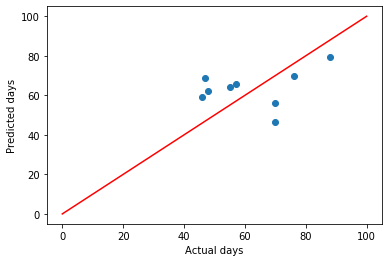

In [83]:
plt.scatter(y_test, y_predict)
plt.plot([0,100],[0,100],"r")
plt.xlabel("Actual days")
plt.ylabel("Predicted days")

### Checking the model performance

In [84]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [85]:
lin_mse = mean_squared_error(y_test, y_predict)
lin_rmse = np.sqrt(lin_mse)
lin_r2 = r2_score(y_test, y_predict)

In [86]:
print(f"RMSE: {lin_rmse}, R2: {lin_r2}")

RMSE: 14.37924567879152, R2: -0.06281122030553443


#### Model performance isn't good. 
**Check the correlation between features and output, also try with different models**
- Lasso/ Ridge regression
- Desicion Tree
- RNN

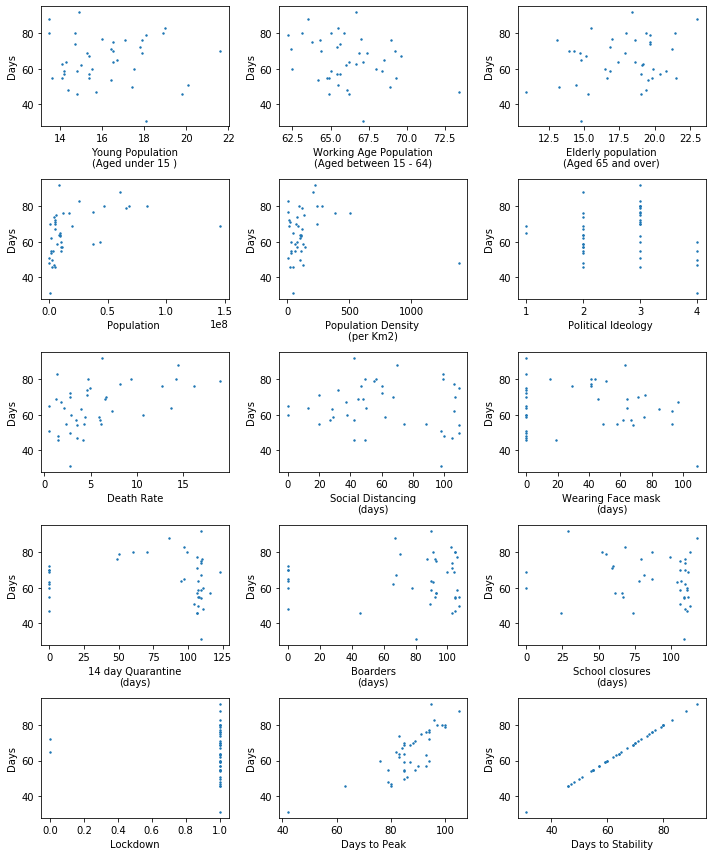

In [87]:
days_to_stability = covid_data.iloc[1:,-1].to_numpy()
plt.figure(figsize=(10,12))
for i, feature in enumerate(covid_data.columns):
    plt.subplot(5,3,i+1)
    features = covid_data.iloc[1:,i].to_numpy()
    plt.scatter(features, days_to_stability, s=2)
    plt.ylabel("Days")
    plt.xlabel(feature)
    plt.tight_layout()

### Ridge regression

In [88]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [89]:
ridge=Ridge(normalize=True)
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_regressor=GridSearchCV(ridge,parameters,scoring='neg_mean_squared_error',cv=5)

In [90]:
ridge_regressor.fit(x_train,y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=True, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [91]:
y_predict_ridge = ridge_regressor.predict(x_test)

Text(0, 0.5, 'Predicted days')

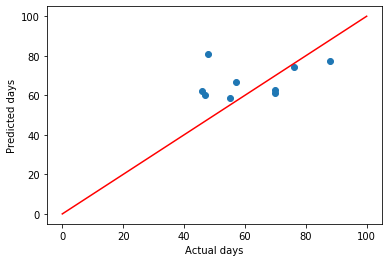

In [92]:
plt.scatter(y_test, y_predict_ridge)
plt.plot([0,100],[0,100],"r")
plt.xlabel("Actual days")
plt.ylabel("Predicted days")

In [93]:
ridge_mse = mean_squared_error(y_test, y_predict_ridge)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, y_predict_ridge)

In [94]:
print(f"RMSE: {ridge_rmse}, R2: {ridge_r2}")

RMSE: 14.361292184764999, R2: -0.060158888850841974


### Lasso Regression

In [95]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [96]:
lasso=Lasso(normalize=True)
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

In [97]:
import warnings
warnings.filterwarnings('ignore')

In [98]:
lasso_regressor.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=True, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.001, 0.01, 1, 5, 10,
                                   20, 30, 35, 40, 45, 50, 55, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [99]:
y_predict_lasso = lasso_regressor.predict(x_test)

Text(0, 0.5, 'Predicted days')

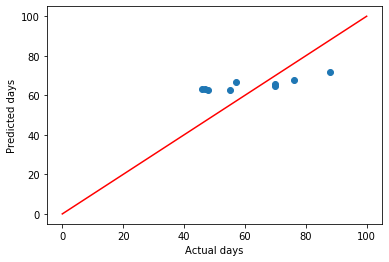

In [100]:
plt.scatter(y_test, y_predict_lasso)
plt.plot([0,100],[0,100],"r")
plt.xlabel("Actual days")
plt.ylabel("Predicted days")

In [101]:
lasso_mse = mean_squared_error(y_test, y_predict_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_test, y_predict_lasso)

In [102]:
print(f"RMSE: {lasso_rmse}, R2: {lasso_r2}")

RMSE: 12.096687915499894, R2: 0.24782849723790512


### Decision tree

In [103]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [104]:
tree_reg_prediction = tree_reg.predict(x_test)

Text(0, 0.5, 'Predicted days')

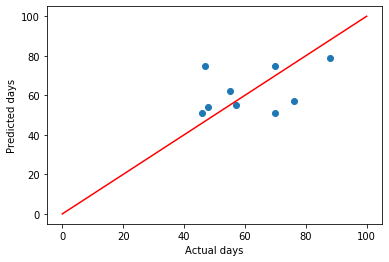

In [105]:
plt.scatter(y_test, tree_reg_prediction)
plt.plot([0,100],[0,100],"r")
plt.xlabel("Actual days")
plt.ylabel("Predicted days")

In [106]:
tree_mse = mean_squared_error(y_test, tree_reg_prediction)
tree_rmse = np.sqrt(tree_mse)
tree_r2 = r2_score(y_test, tree_reg_prediction)

In [107]:
print(f"RMSE: {tree_rmse}, R2: {tree_r2}")

RMSE: 13.848385385227326, R2: 0.014215001903794988


#### Result 
- linear Regression: RMSE: 14.37924567879152, R2: -0.06281122030553443
- Ridge Regression: RMSE: 14.361292184765, R2: -0.06015888885084242
- Lasso Regression: RMSE: 12.096687915499892, R2: 0.24782849723790523
- Decision tree: RMSE: 13.848385385227326, R2: 0.014215001903794988
- **Conclusion: Lasso Regression has the best performance in machine learning**

In [108]:
import seaborn as sns

#### Plotting the performance

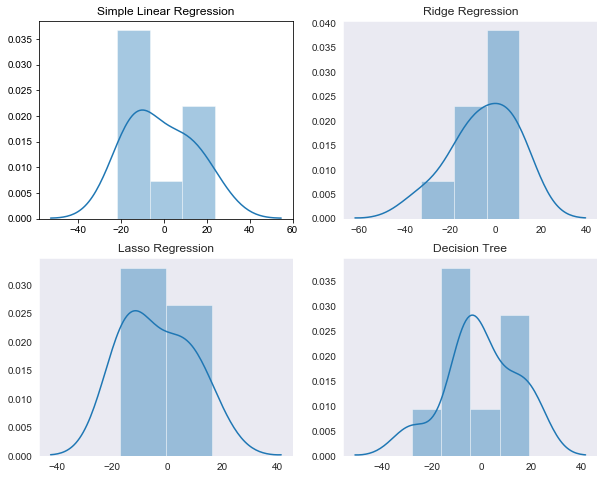

In [109]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
sns.set_style('dark')
plt.title('Simple Linear Regression');
sns.distplot(y_test - y_predict, kde=True)

plt.subplot(2, 2, 2)
sns.set_style('dark')
plt.title('Ridge Regression')
sns.distplot(y_test-y_predict_ridge, kde = True)

plt.subplot(2, 2, 3)
sns.set_style('dark')
plt.title('Lasso Regression')
sns.distplot(y_test-y_predict_lasso, kde = True)

plt.subplot(2, 2, 4)
sns.set_style('dark')
plt.title('Decision Tree')
sns.distplot(y_test-tree_reg_prediction, kde = True)

#### Use Lasso Regression to predict when will USA control the pandamic

In [110]:
# build a Lasso model
lasso=Lasso(normalize=True)
parameters={'alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
lasso_regressor_usa=GridSearchCV(lasso,parameters,scoring='neg_mean_squared_error',cv=5)

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
usa = covid_data.loc["USA",:"Days to Peak"]

In [113]:
x_usa = usa.values.reshape(1,14)

In [114]:
y_predict_usa = lasso_regressor.predict(x_usa)

In [115]:
y_predict_usa

array([431.42153959])

In [116]:
usa_starting_date = covid_original.loc[(covid_original["location"] =="United States")&(covid_original["total_cases"]>=30), ["date","total_cases"]]

In [117]:
usa_start = usa_starting_date["date"].tolist()

In [118]:
usa_start[0]

'2020-02-22'

In [119]:
import datetime

In [120]:
lc_case["date"] = pd.to_datetime(lc_case["date"],format="%Y-%m-%d")

In [121]:
usa_start[0] = pd.to_datetime(usa_start[0],format="%Y-%m-%d")

In [122]:
usa_to_stability = usa_start[0] + datetime.timedelta(days=431)

In [123]:
usa_to_stability

Timestamp('2021-04-28 00:00:00')

### USA will reach stability on 2021/04/28

#### Check USA total cases changing timeline

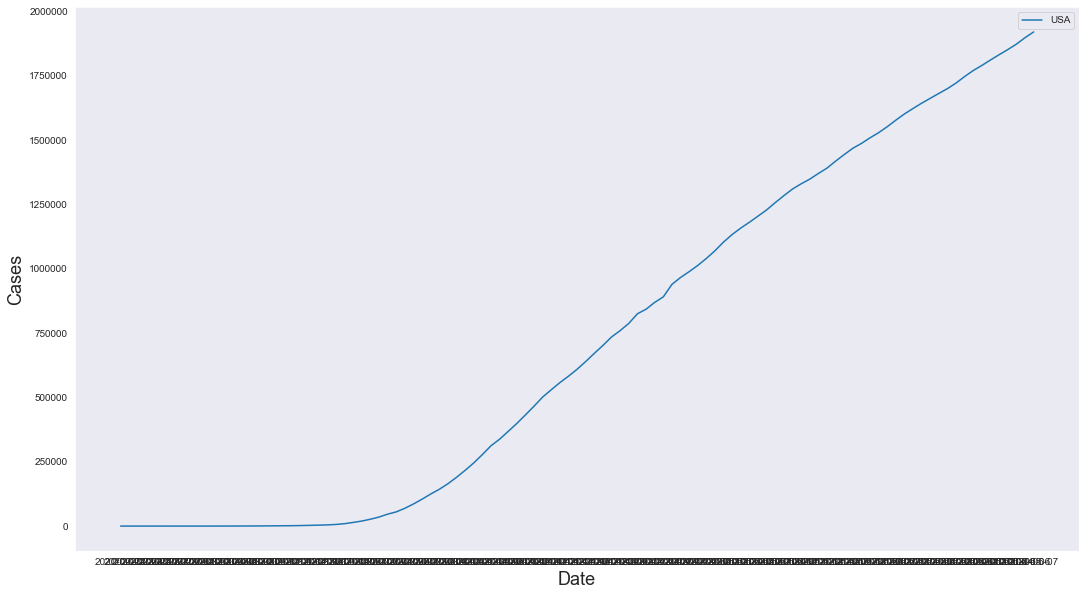

In [124]:
plt.figure(figsize = (18,10))
plt.plot(usa_starting_date["date"],usa_starting_date["total_cases"], label = "USA")
plt.xlabel('Date',fontsize=18)
plt.ylabel('Cases',fontsize=18)
plt.legend(loc='upper right')

## Try with Deep Learning

In [205]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
covid_original = pd.read_csv("owid-covid-data.csv")

In [207]:
covid_original.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'total_deaths', 'new_deaths', 'total_cases_per_million',
       'new_cases_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', 'tests_units',
       'stringency_index', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cvd_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand'],
      dtype='object')

In [208]:
del covid_original["iso_code"]
del covid_original["continent"]

In [209]:
covid_original.set_index("location", inplace= True)

In [210]:
covid_usa = covid_original.loc["United States"]

In [211]:
covid_usa.describe()

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
count,1.600000e+02,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,1.600000e+01,1.000000e+01,...,1.600000e+02,1.600000e+02,1.600000e+02,1.600000e+02,1.600000e+02,1.600000e+02,1.600000e+02,1.600000e+02,0.0,1.600000e+02
mean,4.818536e+05,12000.381250,27032.362500,686.262500,1455.739431,36.254631,81.668094,2.073275,1.494961e+07,6.970305e+05,...,1.541300e+01,9.732000e+00,5.422545e+04,1.200000e+00,1.510890e+02,1.079000e+01,1.910000e+01,2.460000e+01,NaN,2.770000e+00
std,6.433015e+05,12963.617675,38245.464744,905.769054,1943.493459,39.164716,115.544289,2.736452,3.575221e+06,3.766444e+05,...,7.127736e-15,1.603741e-14,2.335617e-10,2.450159e-15,2.851095e-14,2.316514e-14,5.702189e-14,6.414963e-14,NaN,4.900319e-15
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.724879e+06,3.166840e+05,...,1.541300e+01,9.732000e+00,5.422545e+04,1.200000e+00,1.510890e+02,1.079000e+01,1.910000e+01,2.460000e+01,NaN,2.770000e+00
25%,1.200000e+01,0.000000,0.000000,0.000000,0.036000,0.000000,0.000000,0.000000,1.227155e+07,4.447192e+05,...,1.541300e+01,9.732000e+00,5.422545e+04,1.200000e+00,1.510890e+02,1.079000e+01,1.910000e+01,2.460000e+01,NaN,2.770000e+00
50%,1.183250e+04,3911.500000,150.000000,32.500000,35.747500,11.817000,0.453000,0.098000,1.465758e+07,5.331505e+05,...,1.541300e+01,9.732000e+00,5.422545e+04,1.200000e+00,1.510890e+02,1.079000e+01,1.910000e+01,2.460000e+01,NaN,2.770000e+00
75%,9.944840e+05,24135.750000,56772.500000,1299.000000,3004.459500,72.917250,171.516750,3.924250,1.793620e+07,9.350148e+05,...,1.541300e+01,9.732000e+00,5.422545e+04,1.200000e+00,1.510890e+02,1.079000e+01,1.910000e+01,2.460000e+01,NaN,2.770000e+00
max,1.920061e+06,48529.000000,109802.000000,4928.000000,5800.742000,146.612000,331.725000,14.888000,2.038485e+07,1.318362e+06,...,1.541300e+01,9.732000e+00,5.422545e+04,1.200000e+00,1.510890e+02,1.079000e+01,1.910000e+01,2.460000e+01,NaN,2.770000e+00


In [212]:
covid_usa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, United States to United States
Data columns (total 30 columns):
date                               160 non-null object
total_cases                        160 non-null int64
new_cases                          160 non-null int64
total_deaths                       160 non-null int64
new_deaths                         160 non-null int64
total_cases_per_million            160 non-null float64
new_cases_per_million              160 non-null float64
total_deaths_per_million           160 non-null float64
new_deaths_per_million             160 non-null float64
total_tests                        16 non-null float64
new_tests                          10 non-null float64
total_tests_per_thousand           16 non-null float64
new_tests_per_thousand             10 non-null float64
new_tests_smoothed                 18 non-null float64
new_tests_smoothed_per_thousand    18 non-null float64
tests_units                        25 non-null object

In [213]:
covid_usa.dropna(axis =1, inplace = True)

In [214]:
covid_usa = covid_usa.drop(["date"],axis = 1)

In [215]:
covid_usa_test = covid_usa.copy()

#### Ignore the columns that store same value, so only take from first column to "new_deaths_per_million" 

In [216]:
covid_usa_test = covid_usa_test.loc[:,:"new_deaths_per_million"]

In [217]:
covid_usa_test

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million
location,,,,,,,,
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000
United States,0,0,0,0,0.000,0.000,0.000,0.000


In [218]:
#covid_usa_test.replace("tests performed",1, inplace = True)

#### Since all the features have different magnitude and unit, implementing normalization to better fit the model. However, after normalizing, several values in covid_usa were transformed to infinite number which the model couldn't calculate upon. I removed the normalization process to make the model work.

In [219]:
def normalize(df):
    #df = df.drop(["date"], axis=1)
    df_norm = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return df_norm

In [220]:
df_usa = normalize(covid_usa_test)

In [221]:
df_usa

,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million
location,,,,,,,,
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258
United States,-0.250957,-0.247283,-0.246192,-0.139258,-0.250957,-0.247283,-0.246192,-0.139258


In [222]:
print(len(covid_usa.columns))

20


#### Input 30 days of data and predict 5 days 
- take all the data as training data

In [223]:
def train_windows(df, ref_day=30, predict_day=5):
    X_train, Y_train = [], []
    for i in range(ref_day+predict_day+1,df.shape[0]-5):
        X_train.append(np.array(df.iloc[i-ref_day:i,1:-1]))
        Y_train.append(np.array(df.iloc[i:i+predict_day]["total_cases"]))
    return np.array(X_train), np.array(Y_train)

In [224]:
# Disorganize the time order to prevent overfitting
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

In [225]:
# def splitData(X,Y,rate):
#     X_train = X[int(X.shape[0]*rate):]
#     Y_train = Y[int(Y.shape[0]*rate):]
#     X_test = X[:int(X.shape[0]*rate)]
#     Y_test = Y[:int(Y.shape[0]*rate)]
#     return X_train, Y_train, X_test, Y_test

In [227]:
X_train, Y_train = train_windows(covid_usa_test, 30,5)

In [230]:
X_train

array([[[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        ...,
        [1.000000e+00, 0.000000e+00, 0.000000e+00, 2.400000e-02,
         3.000000e-03, 0.000000e+00],
        [3.000000e+00, 0.000000e+00, 0.000000e+00, 3.300000e-02,
         9.000000e-03, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 3.300000e-02,
         0.000000e+00, 0.000000e+00]],

       [[0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        [0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
         0.000000e+00, 0.000000e+00],
        ...,
        [3.000000e+00, 0.000000e+00, 0.000000

In [231]:
X_test = X_train.copy()

#### Only take the recent 15 days as testing data, and use the testing data to make USA prediction

In [232]:
X_test = X_test[-15:]

In [234]:
Y_test = Y_train.copy()[-15:]

In [235]:
Y_test

array([[1508598, 1528568, 1551853, 1577287, 1601434],
       [1528568, 1551853, 1577287, 1601434, 1622670],
       [1551853, 1577287, 1601434, 1622670, 1643238],
       [1577287, 1601434, 1622670, 1643238, 1662302],
       [1601434, 1622670, 1643238, 1662302, 1681212],
       [1622670, 1643238, 1662302, 1681212, 1699933],
       [1643238, 1662302, 1681212, 1699933, 1721750],
       [1662302, 1681212, 1699933, 1721750, 1747087],
       [1681212, 1699933, 1721750, 1747087, 1770384],
       [1699933, 1721750, 1747087, 1770384, 1790191],
       [1721750, 1747087, 1770384, 1790191, 1811277],
       [1747087, 1770384, 1790191, 1811277, 1831821],
       [1770384, 1790191, 1811277, 1831821, 1851520],
       [1790191, 1811277, 1831821, 1851520, 1872660],
       [1811277, 1831821, 1851520, 1872660, 1897838]])

### Building LSTM model
- Input data of LSTM model needs to be constructed into 3 dimensions. 
X_train has the shape of (113, 30, 28), which mean 113 input records, 30 days as a batch for training, and the data contains 28 features.
- The model consists of 2 LSTM layers, and 2 Dense layers
- The first hidden layer (Dense) has 5 nodes, and an output layer that predicts 5 numerical value.
- The activation function is "sigmoid"
- The optimizor of this model is "Adam", and I adopted "MAE" as loss function 

In [236]:
X_train.shape

(119, 30, 6)

In [237]:
Y_train.shape

(119, 5)

In [238]:
len(Y_train)

119

### Turned off softmax to let model make actual prediction 

In [239]:
def lstm_covid_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5))
    #model.add(Dense(5,activation='softmax'))
    model.compile(loss='MAE', optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [240]:
model = lstm_covid_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 256)           269312    
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 256)           525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 1)             257       
_________________________________________________________________
flatten_3 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 155       
Total params: 795,036
Trainable params: 795,036
Non-trainable params: 0
_________________________________________________________________


### Training Data

In [266]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=1, validation_data=(X_test, Y_test), callbacks=[callback])

Train on 119 samples, validate on 15 samples
Epoch 1/100
119/119 [==============================] - 5s 40ms/step - loss: 260836.2775 - mean_absolute_error: 260836.3125 - val_loss: 1022954.8667 - val_mean_absolute_error: 1022954.9375
Epoch 2/100
119/119 [==============================] - 6s 51ms/step - loss: 257250.9389 - mean_absolute_error: 257251.0312 - val_loss: 1012628.6750 - val_mean_absolute_error: 1012628.7500
Epoch 3/100
119/119 [==============================] - 6s 53ms/step - loss: 253112.5350 - mean_absolute_error: 253112.5000 - val_loss: 1002736.0875 - val_mean_absolute_error: 1002736.0625
Epoch 4/100
119/119 [==============================] - 7s 58ms/step - loss: 251028.7472 - mean_absolute_error: 251028.7500 - val_loss: 992580.1708 - val_mean_absolute_error: 992580.1875
Epoch 5/100
119/119 [==============================] - 7s 60ms/step - loss: 245218.3467 - mean_absolute_error: 245218.3594 - val_loss: 982498.9542 - val_mean_absolute_error: 982499.0000
Epoch 6/100
119/119

119/119 [==============================] - 10s 87ms/step - loss: 116266.0845 - mean_absolute_error: 116266.0859 - val_loss: 596389.8667 - val_mean_absolute_error: 596389.8750
Epoch 45/100
119/119 [==============================] - 7s 57ms/step - loss: 113885.1601 - mean_absolute_error: 113885.1484 - val_loss: 586827.0396 - val_mean_absolute_error: 586827.0625
Epoch 46/100
119/119 [==============================] - 7s 61ms/step - loss: 111056.6134 - mean_absolute_error: 111056.5938 - val_loss: 576127.5104 - val_mean_absolute_error: 576127.4375
Epoch 47/100
119/119 [==============================] - 8s 65ms/step - loss: 107847.6000 - mean_absolute_error: 107847.5938 - val_loss: 567235.1792 - val_mean_absolute_error: 567235.1875
Epoch 48/100
119/119 [==============================] - 7s 59ms/step - loss: 105362.4405 - mean_absolute_error: 105362.4609 - val_loss: 557394.1937 - val_mean_absolute_error: 557394.1875
Epoch 49/100
119/119 [==============================] - 8s 66ms/step - loss: 

119/119 [==============================] - 15s 123ms/step - loss: 38789.0603 - mean_absolute_error: 38789.0586 - val_loss: 240446.9677 - val_mean_absolute_error: 240446.9531
Epoch 89/100
119/119 [==============================] - 10s 85ms/step - loss: 36982.2335 - mean_absolute_error: 36982.2344 - val_loss: 234744.5401 - val_mean_absolute_error: 234744.5312
Epoch 90/100
119/119 [==============================] - 10s 81ms/step - loss: 36697.1275 - mean_absolute_error: 36697.1172 - val_loss: 228502.7083 - val_mean_absolute_error: 228502.7188
Epoch 91/100
119/119 [==============================] - 17s 139ms/step - loss: 36713.0376 - mean_absolute_error: 36713.0469 - val_loss: 222494.4688 - val_mean_absolute_error: 222494.4844
Epoch 92/100
119/119 [==============================] - 16s 131ms/step - loss: 35181.0655 - mean_absolute_error: 35181.0703 - val_loss: 217419.3083 - val_mean_absolute_error: 217419.3281
Epoch 93/100
119/119 [==============================] - 17s 141ms/step - loss: 3

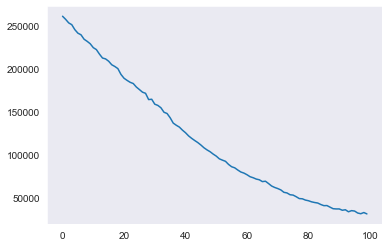

In [267]:
plt.plot(history.history['loss'])

In [268]:
real_date = Y_test

In [269]:
real_date

array([[1508598, 1528568, 1551853, 1577287, 1601434],
       [1528568, 1551853, 1577287, 1601434, 1622670],
       [1551853, 1577287, 1601434, 1622670, 1643238],
       [1577287, 1601434, 1622670, 1643238, 1662302],
       [1601434, 1622670, 1643238, 1662302, 1681212],
       [1622670, 1643238, 1662302, 1681212, 1699933],
       [1643238, 1662302, 1681212, 1699933, 1721750],
       [1662302, 1681212, 1699933, 1721750, 1747087],
       [1681212, 1699933, 1721750, 1747087, 1770384],
       [1699933, 1721750, 1747087, 1770384, 1790191],
       [1721750, 1747087, 1770384, 1790191, 1811277],
       [1747087, 1770384, 1790191, 1811277, 1831821],
       [1770384, 1790191, 1811277, 1831821, 1851520],
       [1790191, 1811277, 1831821, 1851520, 1872660],
       [1811277, 1831821, 1851520, 1872660, 1897838]])

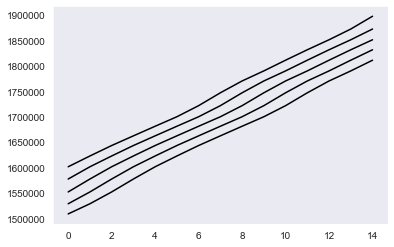

In [270]:
plt.plot(real_date, color = 'black', label = 'Covid Real Data(USA)')

In [271]:
predicted_usa = model.predict(X_test)

In [272]:
predicted_usa

array([[1441249.2, 1472813.6, 1504108.9, 1532007.2, 1562819.2],
       [1441809.5, 1473384.5, 1504689.4, 1532598. , 1563421.4],
       [1441800.6, 1473376.1, 1504674.5, 1532585.6, 1563405.8],
       [1441572.4, 1473136. , 1504419.1, 1532315.5, 1563119.8],
       [1442116.4, 1473691.9, 1504995.6, 1532900.9, 1563723.6],
       [1442083.8, 1473657.9, 1504962. , 1532867.1, 1563690. ],
       [1442002.5, 1473578.2, 1504877.8, 1532784.4, 1563604.9],
       [1441403.8, 1472952.2, 1504218.1, 1532094.8, 1562878.6],
       [1442203.5, 1473777.8, 1505079.6, 1532983.4, 1563803.9],
       [1442250.2, 1473824.9, 1505127. , 1533030.6, 1563851.5],
       [1442257.8, 1473832.1, 1505134.5, 1533037.6, 1563858.8],
       [1442267.5, 1473841.8, 1505144. , 1533047.1, 1563867.9],
       [1442198. , 1473772.5, 1505073.5, 1532977.6, 1563797.8],
       [1442247.2, 1473821.1, 1505120. , 1533022.6, 1563841. ],
       [1442849.1, 1474420.5, 1505709.2, 1533606.1, 1564414.1]],
      dtype=float32)

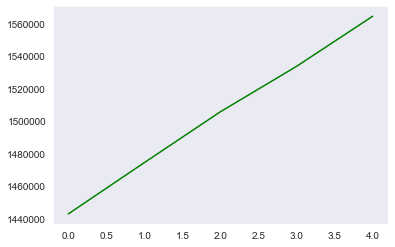

In [273]:
plt.plot(predicted_usa[-1], color = 'green', label = 'Predicted Covid Situation')

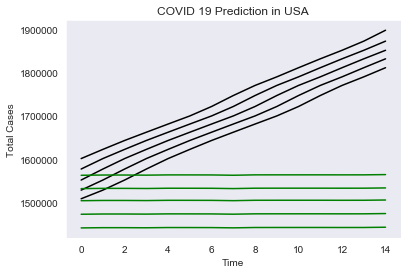

In [274]:
plt.plot(real_date, color = 'black', label = 'Covid19 Real Data(USA)')
plt.plot(predicted_usa, color = 'green', label = 'Predicted USA Covid19 Situation')
plt.title('COVID 19 Prediction in USA')
plt.xlabel('Time')
plt.ylabel('Total Cases')
plt.show()

#### The performance was poor, try to scale down the model to input 5 days and output predict 

In [282]:
covid_usa.shape

(160, 20)

In [283]:
def train_windows(df, ref_day=5, predict_day=1):
    X_train, Y_train = [], []
    for i in range(ref_day+predict_day+1,df.shape[0]-1):
        X_train.append(np.array(df.iloc[i-ref_day:i,1:-5]))
        Y_train.append(np.array(df.iloc[i:i+predict_day]["total_cases"]))
    return np.array(X_train), np.array(Y_train)

In [276]:
def lstm_covid_model(shape):
    model = Sequential()
    model.add(LSTM(256, input_length=shape[1], input_dim=shape[2], return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5))
    model.add(Dense(1))
    model.compile(loss='MAE', optimizer="adam",metrics=['mean_absolute_error'])
    model.summary()
    return model

In [284]:
X_train, Y_train = train_windows(covid_usa_test, 5,1)

In [285]:
X_test = X_train.copy()
X_test = X_test[-10:]

In [286]:
Y_test = Y_train.copy()
Y_test = Y_test[-10:]

In [287]:
X_test.shape

(10, 5, 2)

In [288]:
Y_test.shape

(10, 1)

In [292]:
model = lstm_covid_model(X_train.shape)
callback = EarlyStopping(monitor="mean_absolute_error", patience=10, verbose=1, mode="auto")

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 5, 256)            265216    
_________________________________________________________________
lstm_8 (LSTM)                (None, 5, 256)            525312    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_4 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 6         
Total params: 790,821
Trainable params: 790,821
Non-trainable params: 0
________________________________________________

In [294]:
history= model.fit(X_train, Y_train, epochs=160, batch_size=1, validation_data=(X_test, Y_test), callbacks=[callback])

Train on 152 samples, validate on 10 samples
Epoch 1/160
152/152 [==============================] - 2s 14ms/step - loss: 474956.4344 - mean_absolute_error: 474956.3125 - val_loss: 1745916.4750 - val_mean_absolute_error: 1745916.3750
Epoch 2/160
152/152 [==============================] - 2s 15ms/step - loss: 470390.6243 - mean_absolute_error: 470390.6875 - val_loss: 1733791.9000 - val_mean_absolute_error: 1733792.0000
Epoch 3/160
152/152 [==============================] - 2s 14ms/step - loss: 465981.5725 - mean_absolute_error: 465981.6250 - val_loss: 1720465.1375 - val_mean_absolute_error: 1720465.2500
Epoch 4/160
152/152 [==============================] - 2s 13ms/step - loss: 459015.7242 - mean_absolute_error: 459015.6250 - val_loss: 1704701.5250 - val_mean_absolute_error: 1704701.3750
Epoch 5/160
152/152 [==============================] - 2s 14ms/step - loss: 452687.8332 - mean_absolute_error: 452687.8438 - val_loss: 1687001.9250 - val_mean_absolute_error: 1687002.0000
Epoch 6/160
152

152/152 [==============================] - 2s 13ms/step - loss: 71203.1572 - mean_absolute_error: 71203.1562 - val_loss: 410675.7750 - val_mean_absolute_error: 410675.7500
Epoch 45/160
152/152 [==============================] - 2s 12ms/step - loss: 74865.3295 - mean_absolute_error: 74865.3438 - val_loss: 371576.2125 - val_mean_absolute_error: 371576.2188
Epoch 46/160
152/152 [==============================] - 2s 12ms/step - loss: 64647.8479 - mean_absolute_error: 64647.8555 - val_loss: 338955.1250 - val_mean_absolute_error: 338955.1562
Epoch 47/160
152/152 [==============================] - 2s 12ms/step - loss: 62708.0585 - mean_absolute_error: 62708.0742 - val_loss: 323478.6500 - val_mean_absolute_error: 323478.6562
Epoch 48/160
152/152 [==============================] - 2s 12ms/step - loss: 51803.4156 - mean_absolute_error: 51803.4258 - val_loss: 295733.8125 - val_mean_absolute_error: 295733.8125
Epoch 49/160
152/152 [==============================] - 2s 12ms/step - loss: 52248.2468 

152/152 [==============================] - 2s 11ms/step - loss: 31004.2325 - mean_absolute_error: 31004.2246 - val_loss: 96510.9250 - val_mean_absolute_error: 96510.9219
Epoch 89/160
152/152 [==============================] - 2s 11ms/step - loss: 35054.0749 - mean_absolute_error: 35054.0781 - val_loss: 84619.7500 - val_mean_absolute_error: 84619.7500
Epoch 90/160
152/152 [==============================] - 2s 10ms/step - loss: 31027.0738 - mean_absolute_error: 31027.0684 - val_loss: 72728.3750 - val_mean_absolute_error: 72728.3750
Epoch 91/160
152/152 [==============================] - 2s 11ms/step - loss: 32958.4390 - mean_absolute_error: 32958.4336 - val_loss: 193090.3750 - val_mean_absolute_error: 193090.3750
Epoch 92/160
152/152 [==============================] - 2s 13ms/step - loss: 35297.8714 - mean_absolute_error: 35297.8672 - val_loss: 105308.8500 - val_mean_absolute_error: 105308.8516
Epoch 93/160
152/152 [==============================] - 2s 13ms/step - loss: 30967.3391 - mean

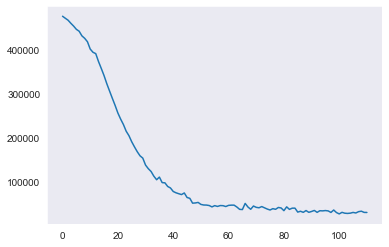

In [295]:
plt.plot(history.history['loss'])

In [296]:
real_date = Y_test

In [297]:
real_date

array([[1699933],
       [1721750],
       [1747087],
       [1770384],
       [1790191],
       [1811277],
       [1831821],
       [1851520],
       [1872660],
       [1897838]])

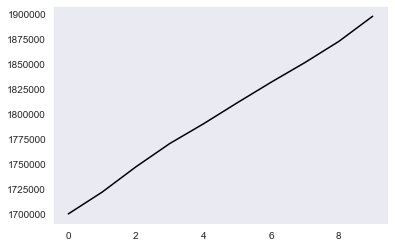

In [298]:
plt.plot(real_date, color = 'black', label = 'Covid Real Data(USA)')

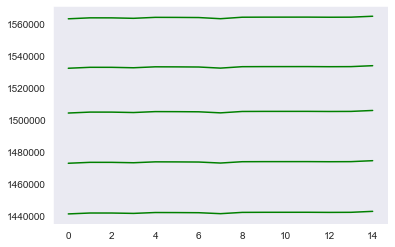

In [299]:
plt.plot(predicted_usa, color = 'green', label = 'Predicted Covid Situation')

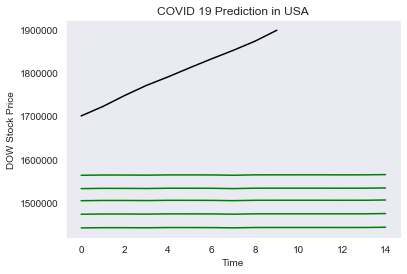

In [300]:
plt.plot(real_date, color = 'black', label = 'Covid19 Real Data(USA)')
plt.plot(predicted_usa, color = 'green', label = 'Predicted USA Covid19 Situation')
plt.title('COVID 19 Prediction in USA')
plt.xlabel('Time')
plt.ylabel('DOW Stock Price')
plt.show()